# This notebook shows the experiments related to ZEB2 ChIP-seq on MM001 cell line.

#### Processed ZEB2 ChIP-seq (Antibody and input), ATAC-seq, and SOX10 ChIP-seq on MM001 files are in ./data/chip_seq
#### ZEB2 ChIP-seq summit file is in ./data/chip_seq
#### The notebook consists of:
* Plotting ZEB2 vs SOX10 ChIP-seq values compared with accessibility.
* Finding and plotting regions with high ZEB2 signal.
* Plotting ZEB2 and SOX10 ChIP-seq values on irf4 locus
#### Figures are saved to ./figures/chip_seq folder

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading bigwig files

In [2]:
import pyBigWig

Zeb2_Ab2_bw = pyBigWig.open("data/chip_seq/ChIPseq_MM001_ZEB2_Ab2.bwa.out.fixmate.possorted.dedup.noblacklist.RPGCnormalized.bw")
input_bw = pyBigWig.open("data/chip_seq/ChIPseq_MM001_input.bwa.out.fixmate.possorted.dedup.noblacklist.RPGCnormalized.bw")
ATAC_MM001_bw = pyBigWig.open("data/chip_seq/ATAC_MM001.sorted.dedup.q30.bw")
Sox10_bw = pyBigWig.open("data/chip_seq/SOX10_ChIP.bw")

### Loading top 3000 ZEB2 peaks and calculating ATAC and ChIP-seq coverage on these regions

In [3]:
Zeb2_Ab2_values = []
input_values = []
ATAC_MM001_values = []
region_id = []
Sox10_values = []
with open("data/chip_seq/MM001_ZEB2_Ab2_summits_top3k_500bp.bed","r") as fr:
    for line in fr:
        chr_ = line.strip().split("\t")[0]
        if chr_.endswith("_alt") or chr_.endswith("_random") or chr_.startswith("chrUn") :
            continue
        start_ = int(line.strip().split("\t")[1])
        end_ = int(line.strip().split("\t")[2])
        region_id.append([chr_, start_, end_])
        Zeb2_Ab2_values.append(Zeb2_Ab2_bw.stats(chr_, start_, end_))
        input_values.append(input_bw.stats(chr_, start_, end_))
        ATAC_MM001_values.append(ATAC_MM001_bw.stats(chr_, start_, end_))
        Sox10_values.append(Sox10_bw.stats(chr_, start_, end_))

### Plotting ZEB2 vs SOX10 ChIP-seq values compared with accessibility.

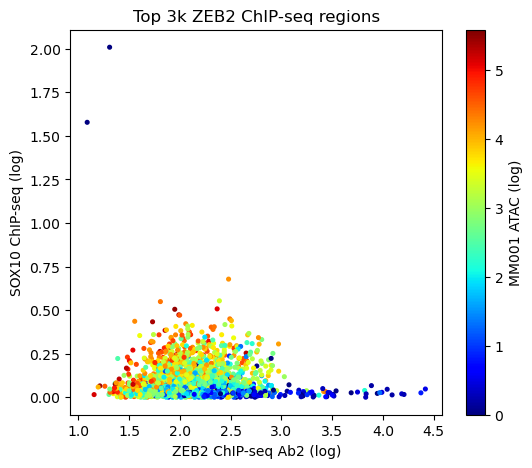

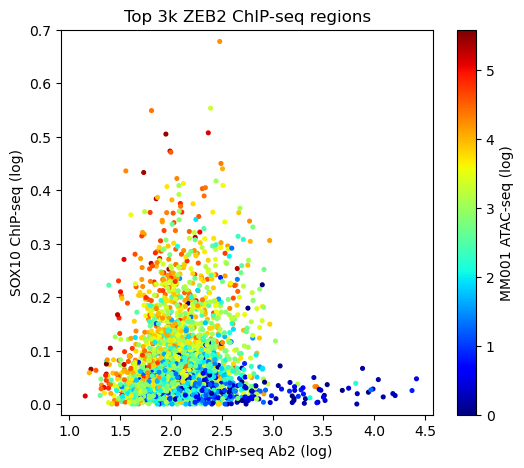

In [4]:
plt.figure(figsize=(6,5))
plt.xlabel("ZEB2 ChIP-seq Ab2 (log)")
plt.ylabel("SOX10 ChIP-seq (log)")
plt.title("Top 3k ZEB2 ChIP-seq regions")
plt.scatter(np.log1p(np.array(Zeb2_Ab2_values)/np.array(input_values)),np.log1p(np.array(Sox10_values)),c=np.log1p(np.array(ATAC_MM001_values)),s=7,cmap='jet')
cb = plt.colorbar()
cb.set_label('MM001 ATAC (log)')

plt.figure(figsize=(6,5))
plt.xlabel("ZEB2 ChIP-seq Ab2 (log)")
plt.ylabel("SOX10 ChIP-seq (log)")
plt.title("Top 3k ZEB2 ChIP-seq regions")
plt.scatter(np.log1p(np.array(Zeb2_Ab2_values)/np.array(input_values)),np.log1p(np.array(Sox10_values)),c=np.log1p(np.array(ATAC_MM001_values)),s=7,cmap='jet')
cb = plt.colorbar()
cb.set_label('MM001 ATAC-seq (log)')
plt.ylim([-0.02,0.7])
plt.savefig("figures/chip_seq/Zeb2_vs_Sox10_ATAC_scatter.pdf",transparent=True)

### Loading DeepMEL2 model

In [5]:
print('Loading data...')
f = open('./data/deepmel2/DeepMEL2_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "deepmel2"
model_json_file = "models/deepmel2/model.json"
model_hdf5_file = "models/deepmel2/model_epoch_07.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])

Loading data...
Loading model...


### Printing the coordinates of the regions with the highest ZEB2 ChIP-seq signal

In [6]:
for i in np.array(region_id)[np.argsort(np.log1p(np.array(Zeb2_Ab2_values)/np.array(input_values))[:,0])[::-1][:3]]:
    print(*i)

chr16 90032296 90032796
chr17 83096431 83096931
chr13 113624773 113625273


### Plotting nucleotide contribution scores together with in silico saturation mutagenesis values for the regions with the highest ZEB2 ChIP-seq signal

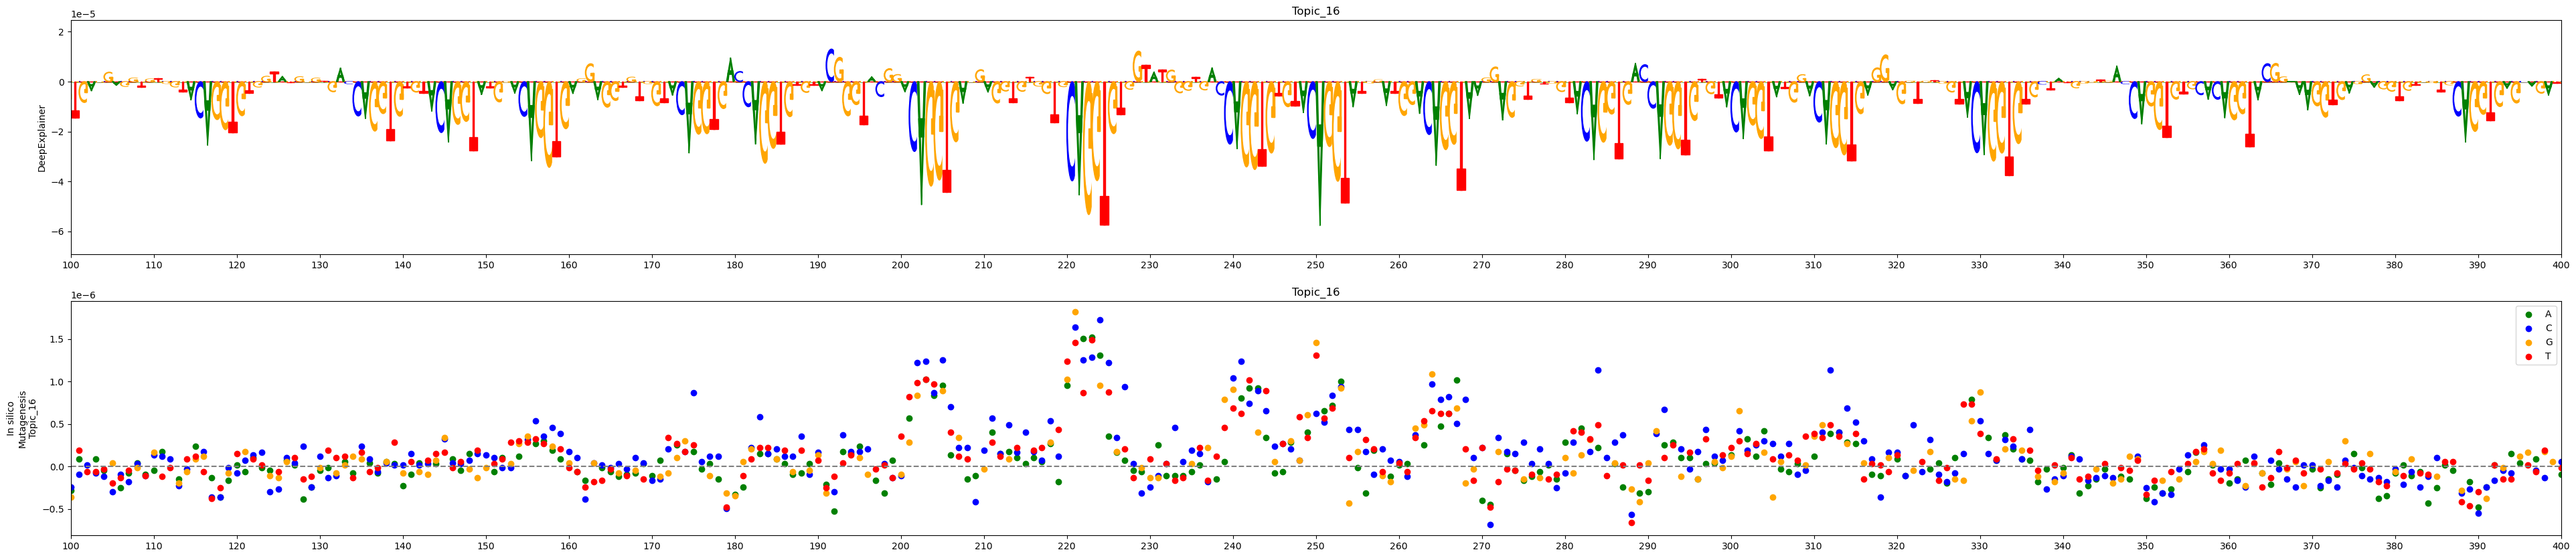

In [7]:
# chr16 90032296 90032796
ntrack = 2
fig = plt.figure(figsize=(48,ntrack*5))
seq_onehot = utils.one_hot_encode_along_row_axis("AGGTGTGGTACAGGTGTGGTGTGGGTGAGCAGGAGTGTACAGGTATGTACAGGTGAGGAGGTGTGGTACAGGTGACCAGGTGTGTACGGGTACGGACAGGTGAGGAGGTGTGGTACAGGTGTGGTATGGGTGACCAGGTGTGTACAGGTATGGACAGGTGAGGAGGTGTGGTACAGGTGACCAGGTGTGTACGGGTACGGACAGGTGAGGAGGTGTGGTGCAGGTGTGGTATGGGTGACCAGGTGTGTACAGGTATGGATGGACAGGTAAGGAGGTGTGGTACAGGTGACCAGGTGTGTACAGGTATGGACAGGTGAGGAGGTGTGGTACAGGTGTGCTATGGGTGACCAGGTGTGCACAGGTACGGAAAGGTGAGGAGGTGTGGTGCAGGTGAGCAGATGGTACTCCCATTGCCCTGCAGGTGTACAAGCAGAAAGTGAAGCACCTGCTATATGAGCACCAGAACAACCTGACAGAGATGAAGGCTGAGGGCACTGTAG")

st = 100
end = 400

ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 16)
ax2 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 16)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/chip_seq/chr16_90032296_90032796_st100_end400_deepexplainer_topic16.pdf",transparent=True)

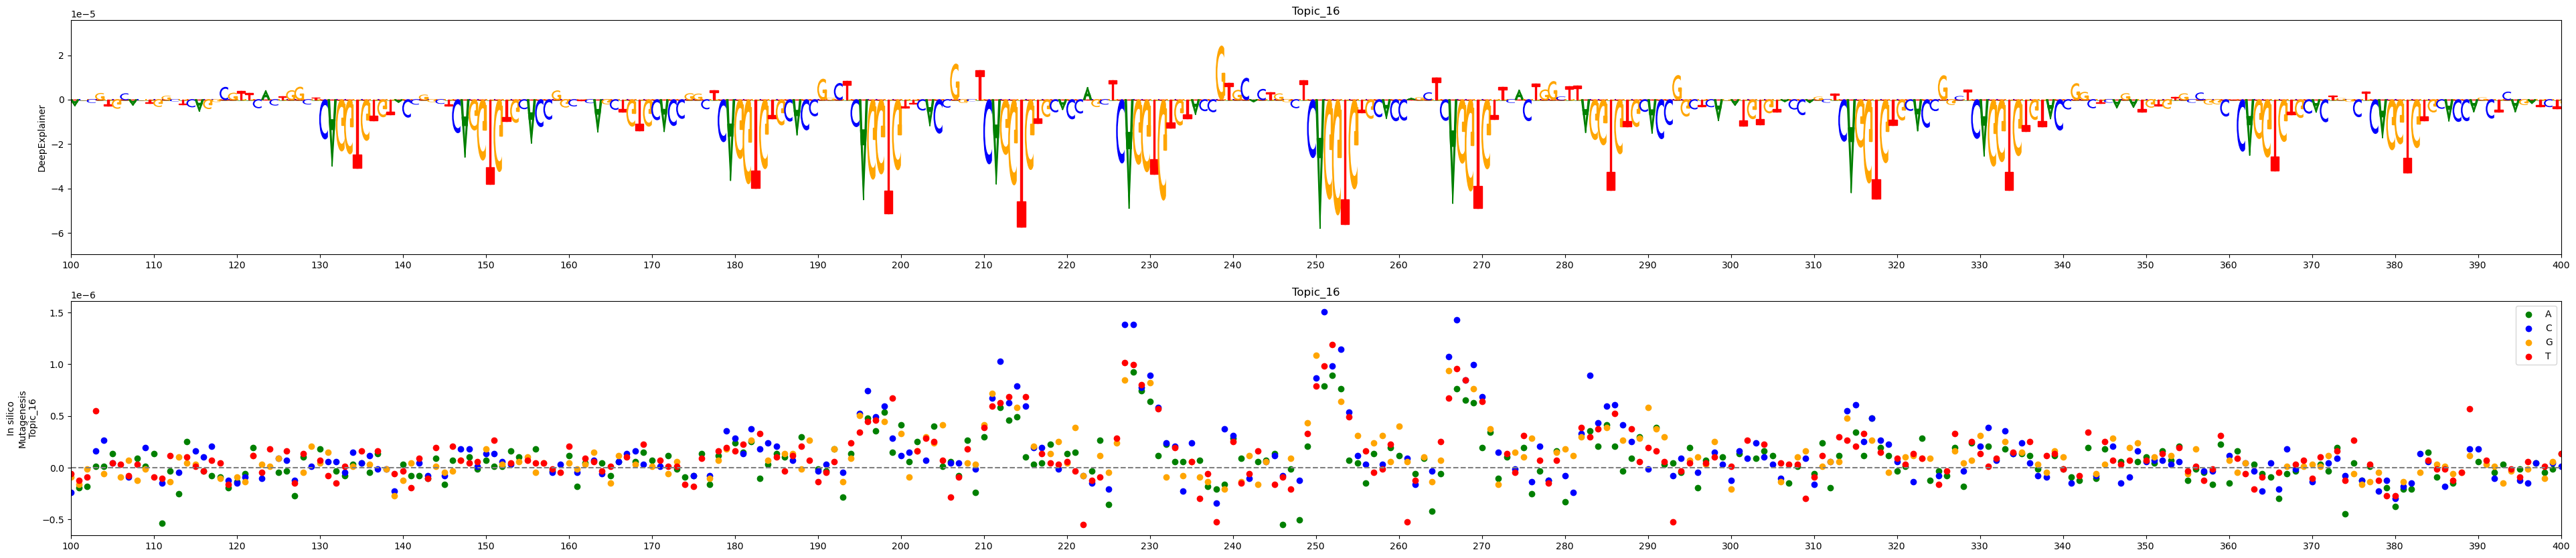

In [8]:
# chr17 83096431 83096931
ntrack = 2
fig = plt.figure(figsize=(48,ntrack*5))
seq_onehot = utils.one_hot_encode_along_row_axis("GTGTACCGGCTCAGGTGTGCACCGGCTCAGCTGTGCACCGGCTCAGCTGTTCACTGGCTCAGGTGTGTACCGGCTCAGGTGTGCACTGGCTCAGGTGTGTACCGTGCACTGGCTCAGGCGTTCACTGGCTCAGGTGTGTACCGGCTCAGGTGTGCACCGGCTCAGCTGTGCACCGGCTCAGGTGTGCACCGGCTCAGGTGTTCACCGGCTCAGGTGTGCACCAGCTCAGGTGTGTACCGTGCACTGGCTCAGGTGTGCACCAGCTCAGGTGTTCACTGGCTTAGGTGTGCACCGGCTCAGATGTGTACCAGCTCAGGTGTGCACCGGCTCAGGTGTGTACCGGCTCAGATGTGTGCCGGCTCAGGTGTGCACTGGCTCAGGTGTGCACCAGCTCAGATCTGAGCCAGCACAGGTCTGCAGGCTCCCACAGGTCACAACAAGAAGCAGGTGTTTCTGGGCGAGGACCTGAAGCAGCAGGCTGGGGCTGGGCCAGGTCCCAC")

st = 100
end = 400

ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 16)
ax2 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 16)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/chip_seq/chr17_83096431_83096931_st100_end400_deepexplainer_topic16.pdf",transparent=True)


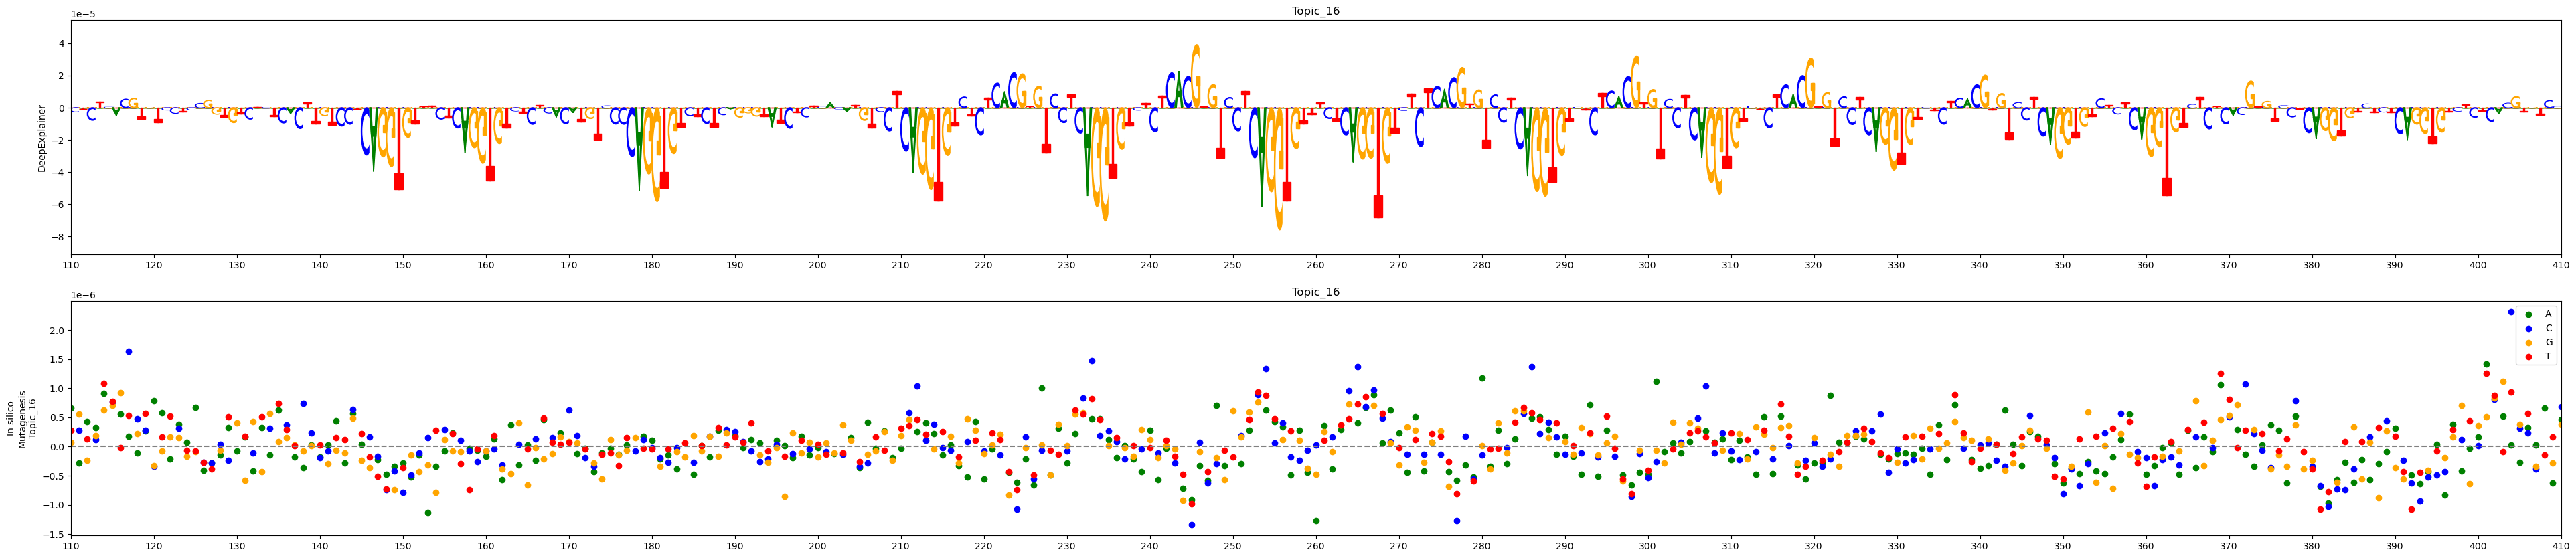

In [9]:
# chr13 113624773 113625273
ntrack = 2
fig = plt.figure(figsize=(48,ntrack*5))
seq_onehot = utils.one_hot_encode_along_row_axis("GTCTCTCAGGGTATCTCTCACATGTCCTCAGGTGTTTCTCAGGTGTCTCTCACGTGTCCTCAGGTGTTTCTCAGGTGTCTCTCACGTGTCCTCAGGTGTTTCTCAGGTGTCTCTCACGTGTCCTCCGGTGTCTCTCACTTGTCCTCAGGTGTTTCTCAGGTGTCTCTCACATGTCCCCAGGTGTCTCTCAGGGTATCTCTCACATGTCCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCACGTGTCCTCAGGTGTTTCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCAGGTGTCTCTCACGTGTCCTCAGGTGTCTCTCACTTGTCCTCAGCTGTTTCTCAGGTGTCTCTCACATGTCCCCAGGTGTCTCTCAGGGTATCTCTCACATGTCCTCAG")

st = 110
end = 410

ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 16)
ax2 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 16)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/chip_seq/chr13_113624773_113625273_st110_end410_deepexplainer_topic16.pdf",transparent=True)


### General imports

In [1]:
import pyBigWig
import pyranges as pr
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading bigwig files

In [2]:
Zeb2_Ab2_bw = pyBigWig.open("data/chip_seq/ChIPseq_MM001_ZEB2_Ab2.bwa.out.fixmate.possorted.dedup.noblacklist.RPGCnormalized.bw")
input_bw = pyBigWig.open("data/chip_seq/ChIPseq_MM001_input.bwa.out.fixmate.possorted.dedup.noblacklist.RPGCnormalized.bw")
ATAC_MM001_bw = pyBigWig.open("data/chip_seq/ATAC_MM001.sorted.dedup.q30.bw")
Sox10_bw = pyBigWig.open("data/chip_seq/SOX10_ChIP.bw")

### Calculating ATAC and ChIP-seq coverage on IRF4 enhancer

In [3]:
irf4_zeb2_ab2 = Zeb2_Ab2_bw.values("chr6", 386829, 416366)
ATAC_MM001_ab2 = ATAC_MM001_bw.values("chr6", 386829, 416366)
SOX10_chip = Sox10_bw.values("chr6", 386829, 416366)

### Loading IRF4 gtf files

In [4]:
pr_gtf = pr.read_gtf("data/IRF4.gtf")
pr_region = pr.read_bed("data/IRF4_locus.bed")

### Function to smooth coverage values

In [5]:
def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

### Plotting the ATAC and ChIP-seq coverages on the IRF4 locus

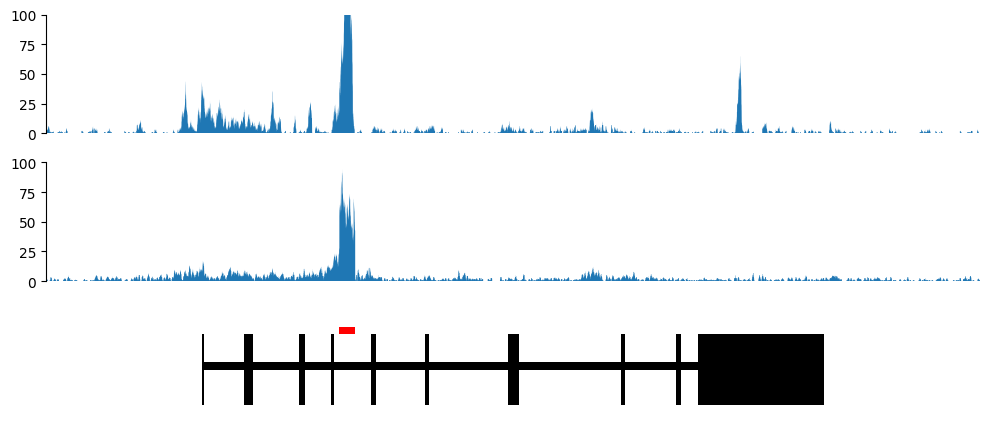

In [29]:
n_tracks = 3
fig = plt.figure(figsize=(10,1.5*n_tracks))

ax  = fig.add_subplot(3,1,1)
ax.fill_between(np.linspace(386829, 416366, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
#ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(3,1,2)
ax.fill_between(np.linspace(386829, 416366, num=len(irf4_zeb2_ab2)),0,irf4_zeb2_ab2)
#ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(3,1,3)

x = np.array(range(386829, 416366, 1))
gtf_region_intersect = pr_gtf.intersect(pr_region)
genes_in_window = set(gtf_region_intersect.gene_name)
n_genes_in_window = len(genes_in_window)
for idx, _gene in enumerate(genes_in_window):
    for _, part in gtf_region_intersect.df.loc[gtf_region_intersect.df['gene_name'] == _gene].iterrows():
        if part['Feature'] == 'exon':
            exon_start = part['Start']
            exon_end = part['End']
            rect = mpatches.Rectangle(
                (exon_start, -1), exon_end-exon_start, 2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
        elif part['Feature'] == 'transcript':
            gene_start = part['Start']
            gene_end = part['End']
            rect = mpatches.Rectangle(
                (gene_start, 0), gene_end-gene_start, 0.2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
    
    # IRF4 enhancer chr6 396106 396605
    rect = mpatches.Rectangle((396106, 1), 396605-396106, 0.2, fill=True, color="r", linewidth=0)
    ax.add_patch(rect)
        
    ax.set_ylim([-2/1.2, 2/1.2])
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)  
    
#ax.set_xlabel("chr6:386829-416366")
fig.tight_layout()
plt.savefig("figures/chip_seq/irf4_locus_atac_ZEB2chip_nolabel.png",transparent=True,dpi=600)

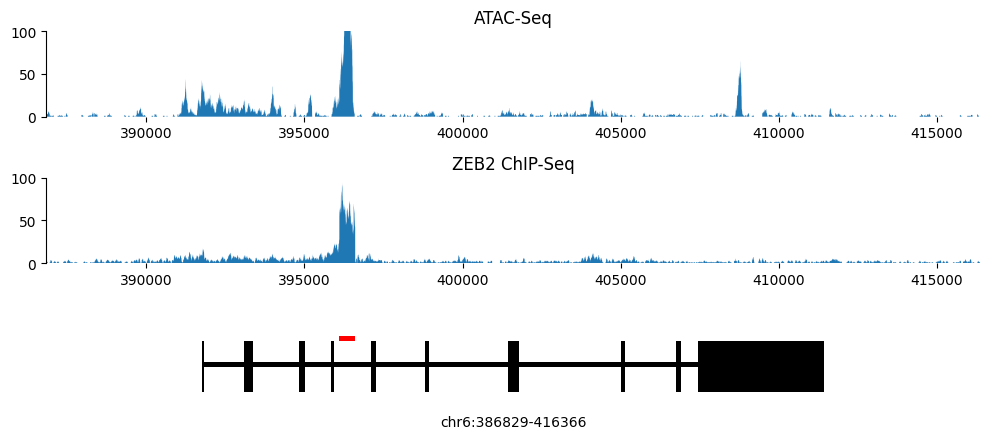

In [28]:
n_tracks = 3
fig = plt.figure(figsize=(10,1.5*n_tracks))

ax  = fig.add_subplot(3,1,1)
ax.fill_between(np.linspace(386829, 416366, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

ax  = fig.add_subplot(3,1,2)
ax.fill_between(np.linspace(386829, 416366, num=len(irf4_zeb2_ab2)),0,irf4_zeb2_ab2)
ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(3,1,3)

x = np.array(range(386829, 416366, 1))
gtf_region_intersect = pr_gtf.intersect(pr_region)
genes_in_window = set(gtf_region_intersect.gene_name)
n_genes_in_window = len(genes_in_window)
for idx, _gene in enumerate(genes_in_window):
    for _, part in gtf_region_intersect.df.loc[gtf_region_intersect.df['gene_name'] == _gene].iterrows():
        if part['Feature'] == 'exon':
            exon_start = part['Start']
            exon_end = part['End']
            rect = mpatches.Rectangle(
                (exon_start, -1), exon_end-exon_start, 2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
        elif part['Feature'] == 'transcript':
            gene_start = part['Start']
            gene_end = part['End']
            rect = mpatches.Rectangle(
                (gene_start, 0), gene_end-gene_start, 0.2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
    
    # IRF4 enhancer chr6 396106 396605
    rect = mpatches.Rectangle((396106, 1), 396605-396106, 0.2, fill=True, color="r", linewidth=0)
    ax.add_patch(rect)
        
    ax.set_ylim([-2/1.2, 2/1.2])
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)  
    
ax.set_xlabel("chr6:386829-416366")
fig.tight_layout()
plt.savefig("figures/chip_seq/irf4_locus_atac_ZEB2chip.pdf",transparent=True)

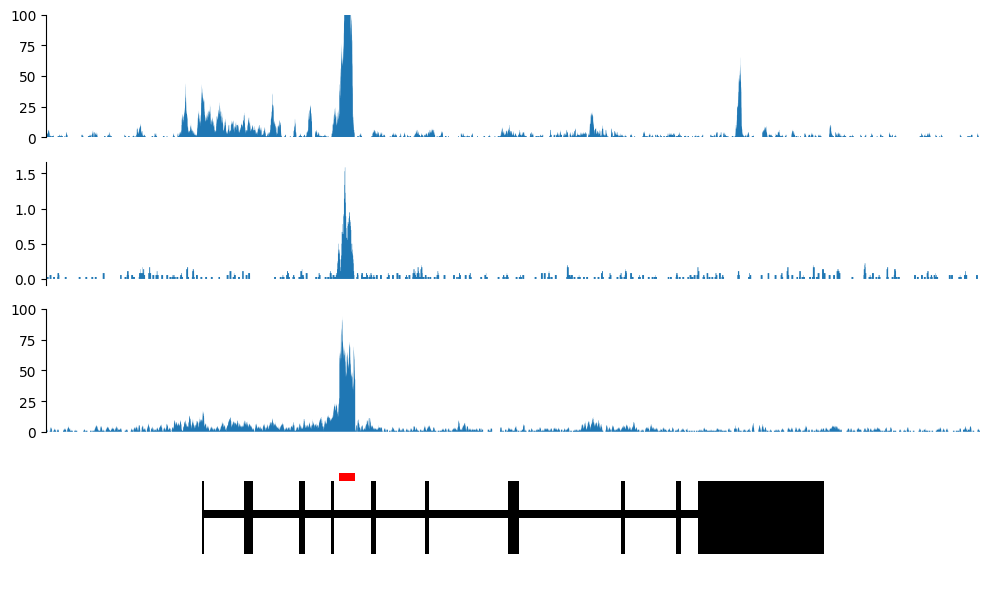

In [9]:
n_tracks = 4
fig = plt.figure(figsize=(10,1.5*n_tracks))

ax  = fig.add_subplot(4,1,1)
ax.fill_between(np.linspace(386829, 416366, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
#ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(4,1,2)
ax.fill_between(np.linspace(386829, 416366, num=len(SOX10_chip)),0,SOX10_chip)
#ax.set_title("SOX10 ChIP-Seq")
ax.margins(x=0)
#ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(4,1,3)
ax.fill_between(np.linspace(386829, 416366, num=len(irf4_zeb2_ab2)),0,irf4_zeb2_ab2)
#ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(4,1,4)

x = np.array(range(386829, 416366, 1))
gtf_region_intersect = pr_gtf.intersect(pr_region)
genes_in_window = set(gtf_region_intersect.gene_name)
n_genes_in_window = len(genes_in_window)
for idx, _gene in enumerate(genes_in_window):
    for _, part in gtf_region_intersect.df.loc[gtf_region_intersect.df['gene_name'] == _gene].iterrows():
        if part['Feature'] == 'exon':
            exon_start = part['Start']
            exon_end = part['End']
            rect = mpatches.Rectangle(
                (exon_start, -1), exon_end-exon_start, 2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
        elif part['Feature'] == 'transcript':
            gene_start = part['Start']
            gene_end = part['End']
            rect = mpatches.Rectangle(
                (gene_start, 0), gene_end-gene_start, 0.2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
    
    # IRF4 enhancer chr6 396106 396605
    rect = mpatches.Rectangle((396106, 1), 396605-396106, 0.2, fill=True, color="r", linewidth=0)
    ax.add_patch(rect)
        
    ax.set_ylim([-2/1.2, 2/1.2])
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)  
    
#ax.set_xlabel("chr6:386829-416366")
fig.tight_layout()
plt.savefig("figures/chip_seq/irf4_locus_atac_SOX10chip_ZEB2chip_nolabel.png",transparent=True,dpi=600)

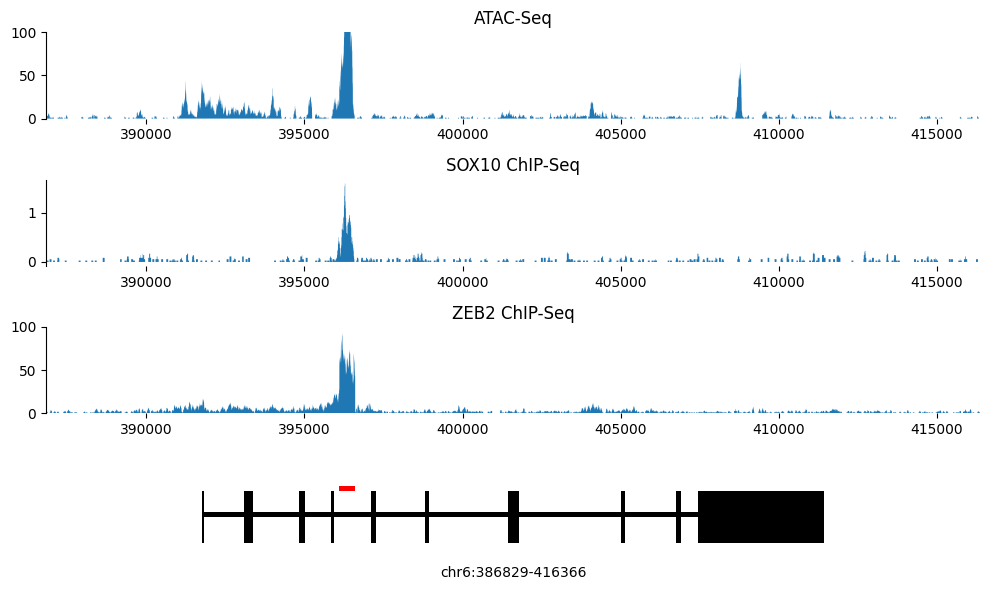

In [12]:
n_tracks = 4
fig = plt.figure(figsize=(10,1.5*n_tracks))

ax  = fig.add_subplot(4,1,1)
ax.fill_between(np.linspace(386829, 416366, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

ax  = fig.add_subplot(4,1,2)
ax.fill_between(np.linspace(386829, 416366, num=len(SOX10_chip)),0,SOX10_chip)
ax.set_title("SOX10 ChIP-Seq")
ax.margins(x=0)
#ax.set_ylim([0,100])

ax  = fig.add_subplot(4,1,3)
ax.fill_between(np.linspace(386829, 416366, num=len(irf4_zeb2_ab2)),0,irf4_zeb2_ab2)
ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(4,1,4)

x = np.array(range(386829, 416366, 1))
gtf_region_intersect = pr_gtf.intersect(pr_region)
genes_in_window = set(gtf_region_intersect.gene_name)
n_genes_in_window = len(genes_in_window)
for idx, _gene in enumerate(genes_in_window):
    for _, part in gtf_region_intersect.df.loc[gtf_region_intersect.df['gene_name'] == _gene].iterrows():
        if part['Feature'] == 'exon':
            exon_start = part['Start']
            exon_end = part['End']
            rect = mpatches.Rectangle(
                (exon_start, -1), exon_end-exon_start, 2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
        elif part['Feature'] == 'transcript':
            gene_start = part['Start']
            gene_end = part['End']
            rect = mpatches.Rectangle(
                (gene_start, 0), gene_end-gene_start, 0.2, fill=True, color="k", linewidth=0)
            ax.add_patch(rect)
    
    # IRF4 enhancer chr6 396106 396605
    rect = mpatches.Rectangle((396106, 1), 396605-396106, 0.2, fill=True, color="r", linewidth=0)
    ax.add_patch(rect)
        
    ax.set_ylim([-2/1.2, 2/1.2])
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)  
    
ax.set_xlabel("chr6:386829-416366")
fig.tight_layout()
plt.savefig("figures/chip_seq/irf4_locus_atac_SOX10chip_ZEB2chip.pdf",transparent=True)

### Plotting the ATAC and ChIP-seq coverages on the regions with the highest ChIP-seq signal

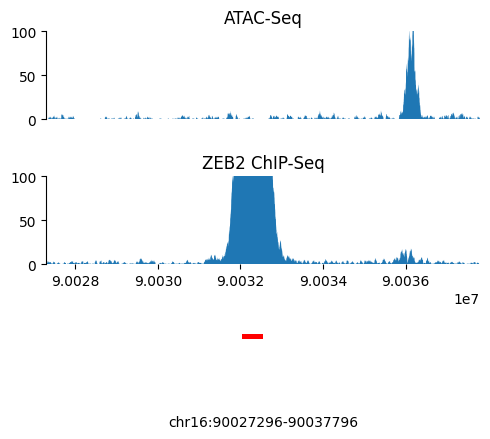

In [6]:
# chr16 90032296 90032796
flank = 5000
chr_ = "chr16"
start = 90032296 - flank
end = 90032796 + flank

zeb2_ab2 = Zeb2_Ab2_bw.values(chr_, start, end)
ATAC_MM001_ab2 = ATAC_MM001_bw.values(chr_, start, end)

n_tracks = 3
fig = plt.figure(figsize=(5,1.5*n_tracks))

ax  = fig.add_subplot(3,1,1)
ax.fill_between(np.linspace(start, end, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(3,1,2)
ax.fill_between(np.linspace(start, end, num=len(zeb2_ab2)),0,zeb2_ab2)
ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(3,1,3)

# IRF4 enhancer chr6 396106 396605
rect = mpatches.Rectangle((start+flank-250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)

ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([start,end])
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0) 
ax.set_xlabel(chr_+":"+str(start)+"-"+str(end))
fig.tight_layout()
plt.savefig("figures/chip_seq/"+chr_+"_"+str(start)+"-"+str(end)+"ATAC_ZEB2ChIP.pdf",transparent=True)

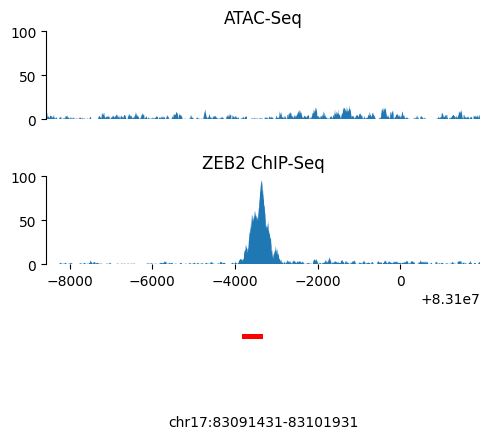

In [7]:
# chr17 83096431 83096931
flank = 5000
chr_ = "chr17"
start = 83096431 - flank
end = 83096931 + flank

zeb2_ab2 = Zeb2_Ab2_bw.values(chr_, start, end)
ATAC_MM001_ab2 = ATAC_MM001_bw.values(chr_, start, end)

n_tracks = 3
fig = plt.figure(figsize=(5,1.5*n_tracks))

ax  = fig.add_subplot(3,1,1)
ax.fill_between(np.linspace(start, end, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(3,1,2)
ax.fill_between(np.linspace(start, end, num=len(zeb2_ab2)),0,zeb2_ab2)
ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(3,1,3)

# IRF4 enhancer chr6 396106 396605
rect = mpatches.Rectangle((start+flank-250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)

ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([start,end])
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0) 
ax.set_xlabel(chr_+":"+str(start)+"-"+str(end))
fig.tight_layout()
plt.savefig("figures/chip_seq/"+chr_+"_"+str(start)+"-"+str(end)+"ATAC_ZEB2ChIP.pdf",transparent=True)

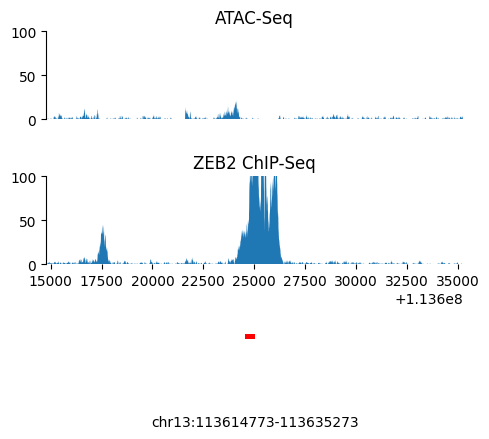

In [8]:
# chr13 113624773 113625273
flank = 10000
chr_ = "chr13"
start = 113624773 - flank
end = 113625273 + flank

zeb2_ab2 = Zeb2_Ab2_bw.values(chr_, start, end)
ATAC_MM001_ab2 = ATAC_MM001_bw.values(chr_, start, end)

n_tracks = 3
fig = plt.figure(figsize=(5,1.5*n_tracks))

ax  = fig.add_subplot(3,1,1)
ax.fill_between(np.linspace(start, end, num=len(ATAC_MM001_ab2)),0,ATAC_MM001_ab2) 
ax.set_title("ATAC-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])
ax.set_xticks([])

ax  = fig.add_subplot(3,1,2)
ax.fill_between(np.linspace(start, end, num=len(zeb2_ab2)),0,zeb2_ab2)
ax.set_title("ZEB2 ChIP-Seq")
ax.margins(x=0)
ax.set_ylim([0,100])

sns.despine(top=True, right=True, bottom=True)

ax = fig.add_subplot(3,1,3)

# IRF4 enhancer chr6 396106 396605
rect = mpatches.Rectangle((start+flank-250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)

ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([start,end])
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0) 
ax.set_xlabel(chr_+":"+str(start)+"-"+str(end))
fig.tight_layout()
plt.savefig("figures/chip_seq/"+chr_+"_"+str(start)+"-"+str(end)+"ATAC_ZEB2ChIP.pdf",transparent=True)